## Imports

In [1]:
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
import torch

## Loss function

In [26]:
# MMR method implemented
def newton(loss_fn, x0, lr=0.1, iteration=100, convergence=1e-6, verbose=False):
    x = x0
    losses = []
    for i in range(iteration):
        
        loss = loss_fn(x)
        # retain graph to calculate hessian
        loss.backward(retain_graph=True)
        
        # Newton step
        hessian = torch.autograd.functional.hessian(loss_fn, x)
        hessian_inv = torch.inverse(hessian)
        grad = torch.autograd.grad(loss, x)
        newton_step = -torch.matmul(hessian_inv, grad[0])
        
        # Line search
        alpha = 1
        while loss_fn(x + alpha*newton_step) > loss_fn(x) + lr*alpha*torch.matmul(grad[0], newton_step):
            alpha *= 0.5
            
        x = x + alpha*newton_step
        
        if torch.norm(alpha*newton_step) < convergence:
            break
            
        if i % 10 == 0 and verbose:
            print(f"Iteration {i}: {loss.item()}")   
            
        losses.append(loss.item())
            
    return x, losses

def mmr_newton(data, k, convergence=1e-6, verbose=False):
    x_data = torch.tensor(data[0])
    y_data = torch.tensor(data[1])
    
    k_evaluated_at_data_points = torch.zeros((len(x_data), len(x_data)))
    for i in range(len(x_data)):
        for j in range(len(x_data)):
            k_evaluated_at_data_points[i, j] = k(x_data[i], y_data[j])
    
    def trial_function_evaluated_at_data_points(a, b):
        result = torch.zeros_like(a)
        result += b
        for i in range(len(a)):
            result += a[i]*k_evaluated_at_data_points[:, i]
        return result
    
    def trial_function(x, a, b):
        result=b
        for i in range(len(a)):
            result += a[i]*k(x, y_data[i])
        return result
    
    def loss_function(alphas):
        b = alphas[0]
        a = alphas[1:]
        y_trial = trial_function_evaluated_at_data_points(a, b)
        result = torch.sum((y_data-y_trial)**2)
        return result
    
    x0 = torch.tensor([torch.sum(x_data)/len(x_data), *torch.zeros_like(y_data)], requires_grad=True)
    
    minimization, losses = newton(loss_function, x0, iteration=100, convergence=convergence, verbose=verbose)
    minimization = minimization.clone().detach().numpy()
    
    b = minimization[0]
    a = minimization[1:]
    
    def optimized_trial_function(x):
        return trial_function(x, a, b)
    
    return optimized_trial_function, losses

## Kernel

### Kernel library

In [124]:
from pennylane.templates import BasicEntanglerLayers, StronglyEntanglingLayers

#classical kernel, k(x, y) = exp(-(x-y)**2/(2*sigma**2))
def K_classical(sigma):
    def k(x, y):
        return torch.exp(-(x-y)**2/(2*sigma**2))
    return k

def make_kernel(U, N):
    def k(x, y):
        @qml.qnode(qml.device('default.qubit', wires=N), interface="torch")
        def kernel_circuit(x, y):
            U(y)
            qml.adjoint(U)(x)
            return qml.probs(wires=range(N))
        
        return kernel_circuit(x, y)[0]
    
    return k

#quantum kernel with a single Rx gate on every qubit as a feature map
def K_simple_RX(N):
    def U(x):
        for n in range(N):
            qml.RX(x, wires=n)

    return make_kernel(U, N)

def K_HEA_RX(N):
    def phi(x, q):
        return q * x / 2
    
    def U(x):
        weights_shape = BasicEntanglerLayers.shape(n_layers=1, n_wires=N)
        weights = [torch.tensor([phi(x, n) for n in range(N)]) for _ in range(weights_shape[0])]
        
        BasicEntanglerLayers(weights, wires=range(N))        
        for n in range(N):
            qml.RX(phi(x, n), wires=n)   
        
   
    return make_kernel(U, N)

In [125]:
x = torch.tensor([0.1, 0.2, 0.3], requires_grad=True)
y = torch.tensor([0.2, 0.3, 0.4], requires_grad=True)

def some_function(x, y):
    return torch.sum(torch.exp(-(x-y)**2/(2*0.1**2)))

z = x.clone().detach().requires_grad_(True)

out = some_function(z, y)


out.backward()
print(x.grad)
print(y.grad)
print(z.grad)

None
tensor([-6.0653, -6.0653, -6.0653])
tensor([6.0653, 6.0653, 6.0653])


### Visualize Kernel

In [126]:
def kernel_subplot(ax, k, N, grid_res=15):
    xs = np.linspace(0, 2*np.pi, grid_res)
    KK = np.array([[k(x, y) for x in xs] for y in xs])

    ax.set_title(rf"$\kappa(x, y)$ for $N={N}$ qubits")
    ax.imshow(KK, extent=(0, 2*np.pi, 0, 2*np.pi))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"])
    ax.set_yticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"])
    
def loss_plot(lossesArray, labels=None):
    for i, losses in enumerate(lossesArray):
        label = labels[i] if labels is not None else f"loss {i}"
        plt.plot(losses, label=label)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.yscale("log")
    plt.legend()
    plt.show()

def compare_plot(f_opt, f_sol, data, xs):
    x = data[0]
    y = data[1]
    plt.plot(x, y, "x", label="data", color="black", alpha=0.5)
    plt.plot(xs, [f_sol(x) for x in xs], label="analytic")
    plt.plot(xs, [f_opt(x) for x in xs], label="opt", linestyle="--")
    plt.ylabel("f(x)")
    plt.xlabel("x")
    plt.legend()
    plt.show()

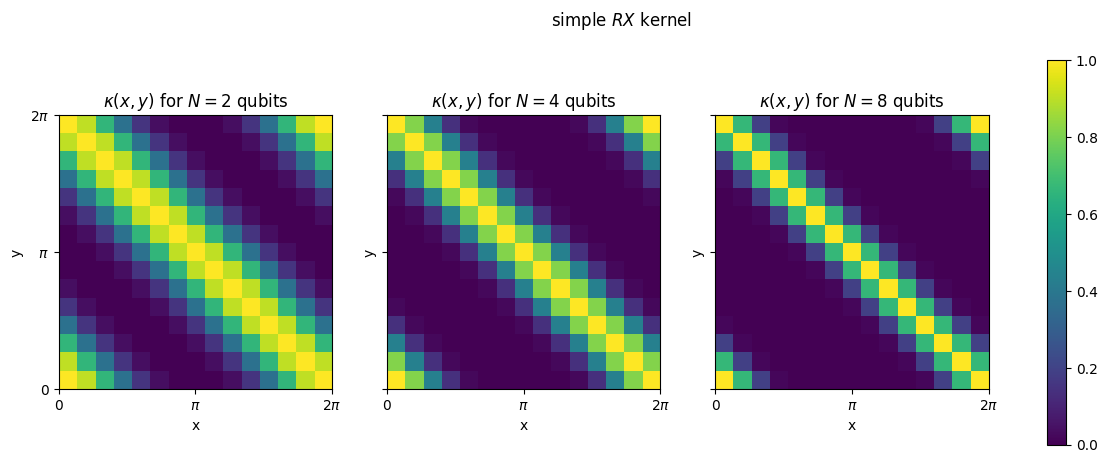

In [127]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle(r"simple $RX$ kernel")
k = K_simple_RX(2)
kernel_subplot(axs[0], k, 2)
k = K_simple_RX(4)
kernel_subplot(axs[1], k, 4)
k = K_simple_RX(8)
kernel_subplot(axs[2], k, 8)
# colorbar
fig.colorbar(axs[2].images[0], ax=axs, orientation="vertical")
plt.show()

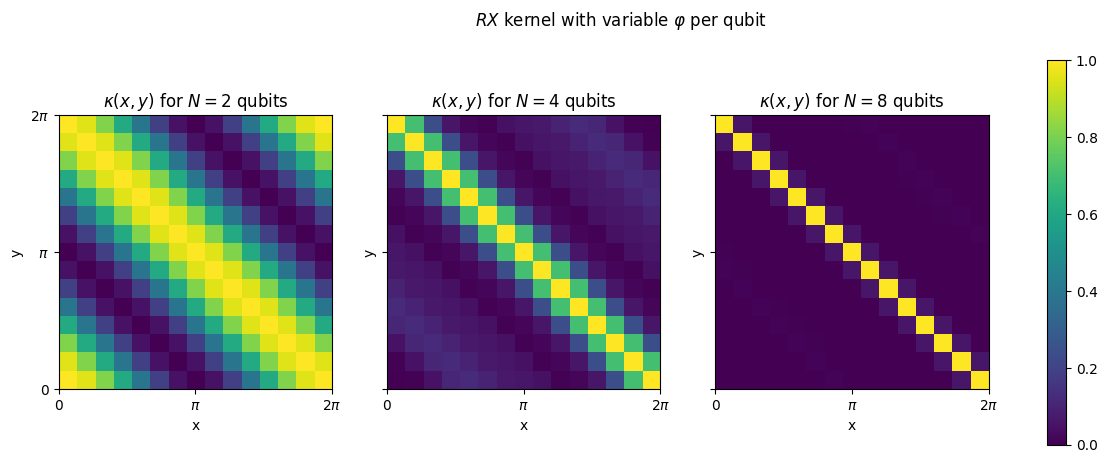

In [128]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle(r"$RX$ kernel with variable $\varphi$ per qubit")
k = K_HEA_RX(2)
kernel_subplot(axs[0], k, 2)
k = K_HEA_RX(4)
kernel_subplot(axs[1], k, 4)
k = K_HEA_RX(8)
kernel_subplot(axs[2], k, 8)
# colorbar
fig.colorbar(axs[2].images[0], ax=axs, orientation="vertical")
plt.show()

## Results

### $f(x) = x^2$

In [81]:
x = np.linspace(0, 0.1, 51)
y = x**2
data = np.array([x, y])

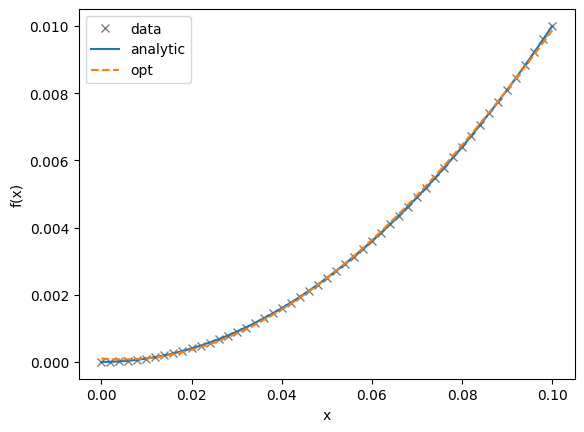

In [82]:
k = K_classical(0.14)
f,_ = mmr_newton(data, k)

compare_plot(f, lambda x: x**2, data, xs=np.linspace(0, 0.1, 100))

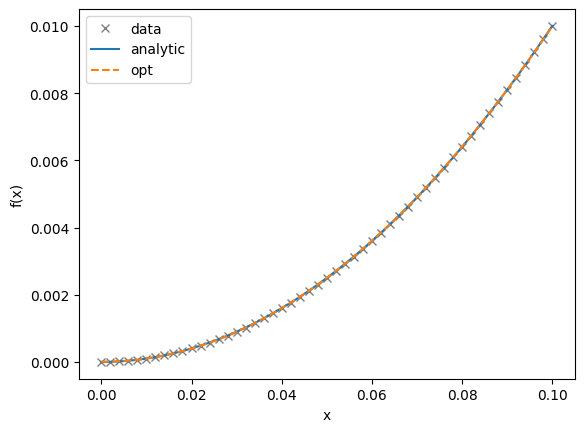

In [83]:
k = K_simple_RX(8)
f,_ = mmr_newton(data, k)

compare_plot(f, lambda x: x**2, data, xs=np.linspace(0, 0.1, 100))

### $f(x) = \exp(x)$

In [84]:
x = np.linspace(0, 5.0, 51)
y = np.exp(x)
data = np.array([x, y])

In [85]:
k = K_classical(0.14)
try:
    f,_ = mmr_newton(data, k)
    plt.plot(x, y, label="trial")
    plt.plot(x, np.array([f(x) for x in x]), label="original")

except RuntimeError as e:
    print(e)

linalg.inv: The diagonal element 22 is zero, the inversion could not be completed because the input matrix is singular.


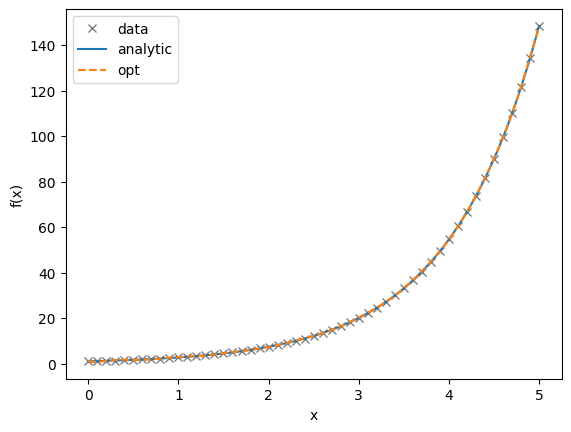

In [86]:
k = K_simple_RX(8)
f, lossesQK = mmr_newton(data, k)

compare_plot(f, np.exp, data, xs=np.linspace(0, 5, 100))

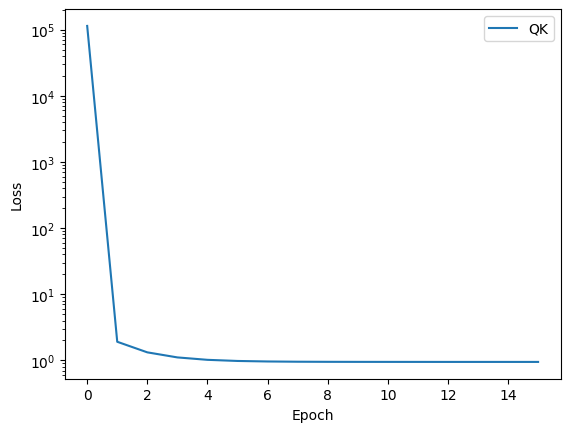

In [87]:
loss_plot([lossesQK], labels=["QK"])

### $\frac{df}{dx} = -\lambda \kappa f - \lambda \exp(\lambda \kappa x)\sin(\lambda x)$

with Solution: $f_{sol}(x) = -\lambda \exp(-\lambda \kappa x)\cos(\lambda x)$

In [88]:
def df_dx(x, f, l, k):
    return -l * k * f -l * np.exp(-l * k * x) * np.sin(l * x)

def f_sol(x, l, k):
    return np.exp(-l*k*x)*np.cos(l*x)

llambda = 20
kk = 0.1

x = np.linspace(0, 1, 21)
y = f_sol(x, llambda, kk)
data = np.array([x, y])

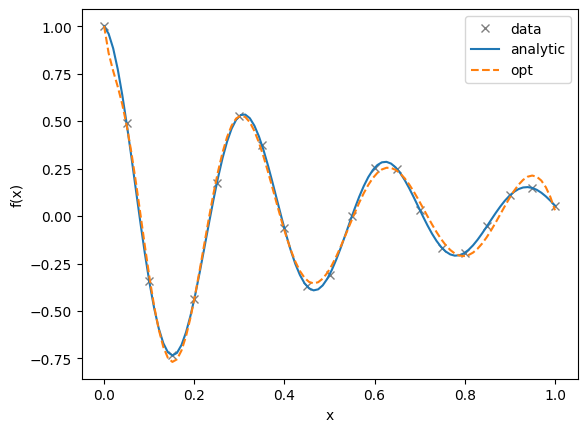

In [89]:
k = K_classical(0.2)
f, lossesRBF = mmr_newton(data, k)
    
compare_plot(f, lambda x: f_sol(x, llambda, kk), data, xs=np.linspace(0, 1, 100))

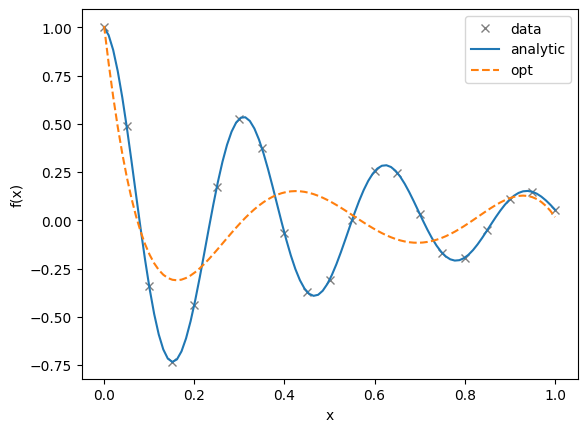

In [92]:
k = K_simple_RX(8)
f, lossesQK_simple = mmr_newton(data, k, convergence=1e-6)

compare_plot(f, lambda x: f_sol(x, llambda, kk), data, xs=np.linspace(0, 1, 100))

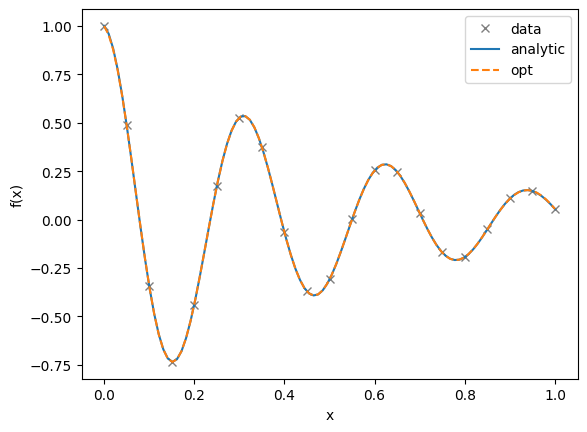

In [90]:
k = K_HEA_RX(8)
f, lossesQK = mmr_newton(data, k, convergence=1e-6)

compare_plot(f, lambda x: f_sol(x, llambda, kk), data, xs=np.linspace(0, 1, 100))

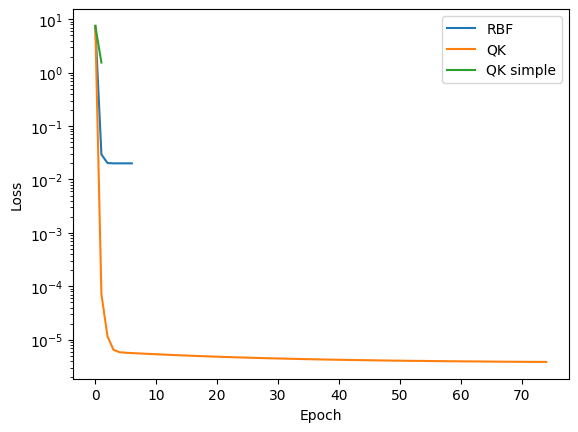

In [93]:
loss_plot([lossesRBF, lossesQK, lossesQK_simple], labels=["RBF", "QK", "QK simple"])